# Homework 8

In this homework you will work on correlation and regression and the links between them.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel
from nistats.hemodynamic_models import glover_hrf as create_hrf
import cortex
from scipy.stats import zscore

Let's define our helper function to load fMRI data:

In [2]:
def load_nifti(filename, zscore=True, mask=None):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if zscore:
        data = (data - data.mean(0)) / (data.std(0) + 1e-7)
    return data

And let's create a response design matrix for the motor localizer:

In [3]:
hrf = create_hrf(tr=2, oversampling=1, time_length=32)

motor_categories = np.load("/home/jovyan/motorloc_experimental_conditions.npy")
unique_motor_categories_no_rest = np.unique(motor_categories[motor_categories != 'rest'])
motor_response_vectors = []
for category in unique_motor_categories_no_rest:
    stimulus_vector = motor_categories == category
    response_vector = np.convolve(stimulus_vector, hrf)[:len(motor_categories)]
    motor_response_vectors.append(response_vector)
motor_response_design = np.stack(motor_response_vectors, axis=1)

**1. Making correlation maps**

In this exercise you will make maps of voxel correlation coefficients. To do this you will write a function that can compute correlation maps of lots of voxels to one response vector. This functionality was used in class. This exercise will help you turn it into a function. On the way, you will learn how to use one aspect of the function `np.dot`, which is versatile and important for data science in general.

**(a)** The cell above prepares a motor response design matrix like you did for the last homework. Use `plt.imshow` to display it (make sure the aspect ratio is even enough to view when each stimulus type is presented), and put the `unique_motor_categories_no_rest` as the x-ticks. Name the figure `fig_motor_design`.

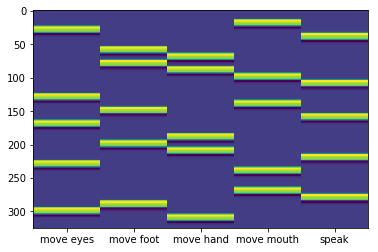

In [4]:
fig_motor_design = plt.figure()
plt.imshow(motor_response_design, aspect='auto')
plt.xticks(np.arange(len(unique_motor_categories_no_rest)), unique_motor_categories_no_rest)
pass

**(b)** The tricky part of the correlation function is to multiply one 1D vector as a column to all the column vectors of a matrix.

Write a function called `multiply_add(one, many)` which takes a 1D vector called `one` and a 2D matrix `many`. Like in class, it should make a column vector out of `one` - call it `one_column` - and then multiply it with `many`, so that each column in `many` gets multiplied by `one_column`. Call that product `one_times_many`. Next, sum the data in each columns (axis 0), resulting in a 1D vector whose length is the number of columns of `many`. Call this vector `product_sums` and return it.

In [5]:
def multiply_add(one, many):
    one_column = one.reshape(one.shape[0], 1)
    one_times_many = one_column * many
    product_sums = one_times_many.sum(axis=0)
    return product_sums

**(c)** Now you can use this `multiply_add` function to create a correlation function that can correlate one response vector with many voxels. To do so, let's remember the recipe for computing correlation: Correlation is the *average of the product of the inputs if they are in standard units*. This means that first you need to get the input into standard units, by z-scoring them. Then you need to compute the average of the products. An average is computed by summing up, then dividing by the number of items. This means that you can use `multiply_add` to sum up the products, and then divide by the number of points. Concretely:

Write a function `correlate(one, many)`, which first zscores `one` and **the columns of** `many` and stores the outputs into `one_zscored` and `many_zscored`. Then use `multiply_add` to compute all the sums of products of `one_zscored` and the columns of `many_zscored`. Call the output `product_sums`. Remember, these are sums, not averages. Turn them into averages by dividing by the number of points, and call the output `product_averages`. Return those.

In [6]:
def correlate(one, many):
    one_zscored = zscore(one)
    many_zscored = zscore(many, axis=0)
    product_sums = multiply_add(one_zscored, many_zscored)
    product_averages = product_sums / len(one)
    return product_averages
    

**(d)** Before applying a new function like this to data, it is prudent to perform a sanity check of its functionality. This is always a good idea and good practice and will help you find bugs in your own code. Here you will compare the output of `correlate` to `np.corrcoef` on random data. If the results correspond, then it is unlikely that your code is wrong.

Create two random arrays using `np.random.rand`, called `one_rand` and `many_rand`, of shape `(50,)` and `(50, 4)` respectively. Compute the correlations of `one_rand` with the columns of `many_rand` using `correlate` and store the result in `c1`. It should be an array of shape `(4,)`. 

Now create an empty list called `c0` that you will populate with a for-loop that iterates over the number of columns of `many_rand` and does the following:
1. In that for loop extract the current column and store it in a name called `this_column`.
2. Calculates the correlation between `one_rand` and `this_column` using `np.corrcoef`. Remember that `np.corrcoef` returns a 2 x 2 matrix, and you want the value that is at location `[0,1]` or `[1,0]`, they are the same.
3. Append the correlation to the list `c0`.

After the for loop, use `np.allclose` to check whether `c1` and `c0` are the same and store the output in `same1`. Print `c1, c0` and `same1`.

In [7]:
one_rand = np.random.rand(50)
many_rand = np.random.rand(50, 4)
c1 = correlate(one_rand, many_rand)
c0 = []
for i in range(many_rand.shape[1]):
    this_column = many_rand[:, i]
    c0.append(np.corrcoef(one_rand, this_column)[0, 1])
same1 = np.allclose(c1, c0)
print(c1, c0, same1)

[-0.06497914  0.04354647 -0.22731647 -0.07230741] [-0.064979140371430946, 0.043546470838608312, -0.22731647426871779, -0.072307406782774655] True


**(e)** Now that you have verified that your correlation function works, let's use it! Let's start by correlating response vector for the `move eyes` condition with all the cortical voxels. Extract the first column from the motor response design column and call it `resp_move_eyes`. 

Then get a cortical mask using pycortex, for subject `s01`, transform `catloc` and `type='cortical'`. Call it mask.

Next, use the `load_nifti` function to load the data from `/data/cogneuro/fMRI/motor/s01_motorloc.nii.gz`, specifying `mask`, and store the output into `data`.

Finally use `correlate` to compute the correlations between `resp_move_eyes` and `data`. Store the result in `corr_move_eyes`.

In [8]:
resp_move_eyes = motor_response_design[:, 0]
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')
data = load_nifti('/data/cogneuro/fMRI/motor/s01_motorloc.nii.gz', mask=mask)
corr_move_eyes = correlate(resp_move_eyes, data)

**(f)** Now let's make a correlation map of these results. To do so, first make a `cortex.Volume` out of `corr_move_eyes`, for subject `s01` and transform `catloc`, and call it `vol_move_eyes`. 

Next, use `cortex.quickflat.make_figure` to display `vol_move_eyes`. 

Finally, set the title of the figure to be `'move eyes'` using `plt.title`.

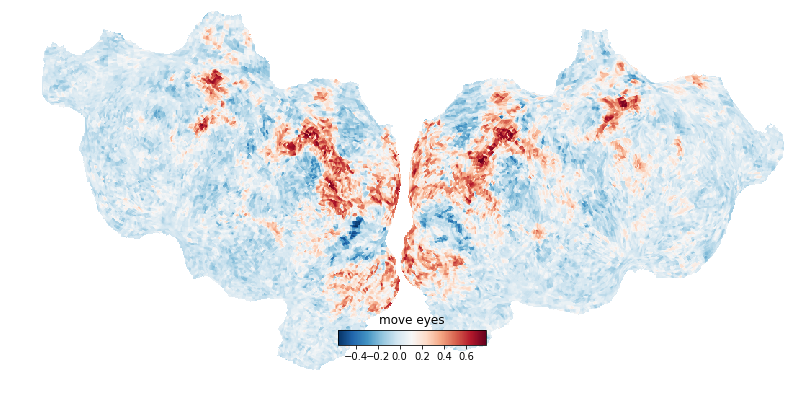

In [9]:
vol_move_eyes = cortex.Volume(corr_move_eyes, 's01', 'catloc')
cortex.quickflat.make_figure(vol_move_eyes)
plt.title("move eyes")

**(g)** Now let's investigate the role of `np.dot`. As it happens, the procedure of comparing vectors by multiplying their entries together and summing the products is the absolutely fundamental operation in linear algebra. It appears all across data analysis in many different incarnations and is useful to know. Since it is so common, it gets its own function called `np.dot` and for our use case, it does exactly what you coded in `multiply_add` in one command.

To see this, write a function `correlate2` by copying and pasting the content of `correlate` and then replacing the occurence of `multiply_add` by `np.dot`. Try out `correlate2` on `one_rand` and `many_rand` and store the result in `c2`. Make sure `c2` is equal to `c0` using `np.allclose`, and sStore the output in `same2`. Print out the values of `c2` and `same2`.

In [10]:
def correlate2(one, many):
    one_zscored = zscore(one)
    many_zscored = zscore(many, axis=0)
    product_sums = np.dot(one_zscored, many_zscored)
    product_averages = product_sums / len(one)
    return product_averages
    
c2 = correlate2(one_rand, many_rand)
same2 = np.allclose(c2, c0)
print(c2, same2)

[-0.06497914  0.04354647 -0.22731647 -0.07230741] True


**(h)** Store the response vector for `move foot` in `resp_move_foot`. Compute its correlation with `data` using `correlate2` and store the result in `corr_move_foot`. Make a pycortex volume out of it and display it as a flat map with the appropriate title.

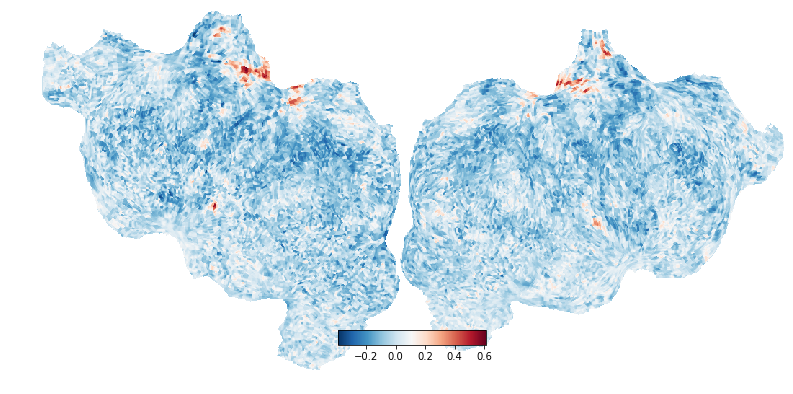

In [18]:
resp_move_foot = motor_response_design[:, 1]
corr_move_foot = correlate2(resp_move_foot, data)
vol_move_foot = cortex.Volume(corr_move_foot, 's01', 'catloc')
cortex.quickflat.make_figure(vol_move_foot)
pass

**2. Univariate linear regressions**

In this exercise you will use linear regression to find the linear relationship between response vectors and some selected voxels.

**(a)** Below there are some voxel indices stored in `voxel_indices`. Use indexing to select the voxel time series corresponding to these voxels from the 4-D scan array called `data`. Call these extracted time series `voxels`.

In [11]:
voxel_indices = [34854, 37594, 36630, 25004, 12135]

In [12]:
voxels = data[:, voxel_indices]

**(b)** Let's try some linear regression using the first response vector (`resp_move_eyes`, already extracted above) and the first voxel. Recall from the lecture that we had established two functions for computing slope and intercept of a linear regression, that you can find below.

Extract the time series of the first column of `voxels` and call it `voxel0`. Compute the slope and intercept of the linear regression between `voxel0` and `resp_move_eyes`, where `resp_move_eyes` is the *independent variable*. Store the output in `slope_eyes` and `intercept_eyes`.

In [13]:
def calc_slope(x, y):
    r = np.corrcoef(x, y)[0,1]
    return r*np.std(y)/np.std(x)

def calc_intercept(x, y):
    return np.mean(y) - calc_slope(x, y) * np.mean(x)

In [14]:
voxel0 = voxels[:, 0]

slope_eyes = calc_slope(resp_move_eyes, voxel0)
intercept_eyes = calc_intercept(resp_move_eyes, voxel0)

**(c)** Now let's visualize the relation between `resp_move_eyes` and `voxel0` by making a scatter plot into which we draw the regression line.

Create a figure named `fig_move_eyes_voxel0` and make a scatter plot of with the data from `resp_move_eyes` on the x-axis and the data from `voxel0` on the y-axis. 

Then use the linear equation with the values `slope_eyes` and `intercept_eyes` to create predicted y-values from `resp_move_eyes`, and call it `y_hat_eyes`. 

Plot the regression line by using `resp_move_eyes` as the x data, and `y_hat_eyes` as the y data. Make it a line plot, not a scatter plot.

Finally, add a title saying `'voxel 0 / move eyes'`

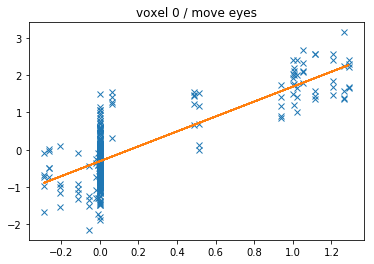

In [21]:
fig_move_eyes_voxel0 = plt.figure()
plt.plot(resp_move_eyes, voxel0, 'x')
y_hat_eyes = slope_eyes * resp_move_eyes + intercept_eyes
plt.plot(resp_move_eyes, y_hat_eyes)
plt.title('voxel 0 / move eyes')

**(d)** Do the same thing as in **(b),(c)** for `resp_move_foot`: Create a figure named `fig_move_foot_voxel0`, plot `resp_move_foot` against `voxel0` as a scatterplot. Compute slope and intercept of the regression. Compute the regression line and call it `y_hat_foot`. Plot the regression line. 

Observe that the slopes of the lines are radically different. These are the behaviors of different response vectors to the same voxel.

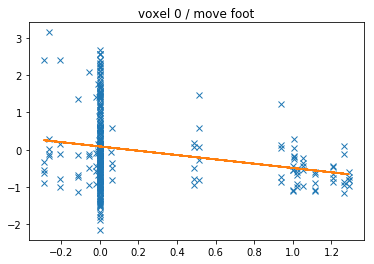

In [22]:
slope_foot = calc_slope(resp_move_foot, voxel0)
intercept_foot = calc_intercept(resp_move_foot, voxel0)

fig_move_foot_voxel0 = plt.figure()
plt.plot(resp_move_foot, voxel0, 'x')
y_hat_foot = slope_foot * resp_move_foot + intercept_foot
plt.plot(resp_move_foot, y_hat_foot)
plt.title('voxel 0 / move foot')

**(e)** Now you can show the exact same information in a line plot. Create a figure named `fig_voxel0_move_eyes_line` of shape `(20, 2)`. Plot `voxel0` and `y_hat_eyes` and `y_hat_foot` into it. Label the x-axis with the appropriate time units. Make a legend. Observe that one `y_hat` vector fits the time series very well, whereas the other is very close to 0, meaning that it doesn't fit this voxel well.

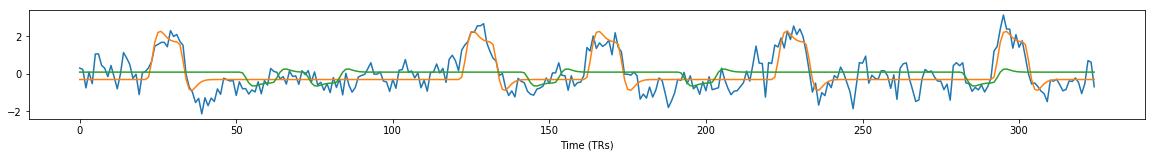

In [26]:
fig_move_eyes_voxel0_line = plt.figure(figsize=(20, 2))
plt.plot(voxel0, label='voxel')
plt.plot(y_hat_eyes, label='eyes')
plt.plot(y_hat_foot, label='foot')
plt.xlabel('Time (TRs)')


**3. True/False Questions**

Below are 4 True/False questions to answer. For each one, create a boolean name called `answer_1` - `answer_4`, and store either `True` or `False` in them.
1. The slope of a linear regression is between -1 and 1.
2. The correlation between x and y is the slope of the best line fit if x and y are in standard units
3. The correlation of x and y and the regression slope between the two are related via the standard deviations of x and y
4. The intercept of a linear regression of x and y in standard units is 0.

In [ ]:
answer_1 = False
answer_2 = True
answer_3 = True
answer_4 = True